## ▶ Data cleaning, EDA, Feature Engineering on Titanic Datatset

### Import necessary libraries

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### load dataset and perform some initial checks

In [2]:
df = pd.read_csv('/kaggle/input/titanic/train.csv')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print('Shape:', df.shape, f'| Rows: {df.shape[0]}, Columns: {df.shape[1]}')

Shape: (891, 12) | Rows: 891, Columns: 12


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The Dtype assignments looks good.

In [6]:
df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [8]:
df.duplicated().sum()

0

No duplication found!

### Fill missing values

In [9]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

There are missing values. Let's check percentage missing.

In [10]:
def perecnt_missing(df):
    missing = {}
    for column in list(df.columns):
        missing[column] = round(100*df[column].isnull().sum()/len(df), 2)
    return json.dumps(missing, indent=4)

In [11]:
missing_percentage_all_col = perecnt_missing(df)
print(missing_percentage_all_col)

{
    "PassengerId": 0.0,
    "Survived": 0.0,
    "Pclass": 0.0,
    "Name": 0.0,
    "Sex": 0.0,
    "Age": 19.87,
    "SibSp": 0.0,
    "Parch": 0.0,
    "Ticket": 0.0,
    "Fare": 0.0,
    "Cabin": 77.1,
    "Embarked": 0.22
}


`Cabin` is missing in 77% of data. This can be removed. Also, `Name` and `Ticket` is not useful for ML model building. So let's remove that.

In [12]:
df = df.drop(['Cabin', 'Name', 'Ticket'], axis=1)

In [13]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

`Embarked` is also missing in two line items. Let's check this.

In [14]:
df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

In [15]:
df[~df['Embarked'].isin(['S', 'C', 'Q'])]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
61,62,1,1,female,38.0,0,0,80.0,NaN
829,830,1,1,female,62.0,0,0,80.0,NaN


`Embarked` is categorical. Let's fill it with mode for the same'

In [16]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [17]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

`Age` is missing in lot of line ites, but not enough so we could it. Let's find if is is corelated to any other column.

In [18]:
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
# plt.show()

Looks like `Age` is somewhat corelated to `PClass` and `SibSp` here. So let's fill Age with mean of the PClass to which the missing lineitem belong to.

In [19]:
def fill_missing_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return int(df[df['Pclass'] == 1]['Age'].mean())
        elif Pclass == 2:
            return int(df[df['Pclass'] == 2]['Age'].mean())
        else:
            return int(df[df['Pclass'] == 3]['Age'].mean())
    else:
        return Age

In [20]:
df['Age'] = df[['Age', 'Pclass']].apply(fill_missing_age, axis=1)

In [21]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

All good now!

### Visualizations

In [22]:
all_dependent_columns = list(df.columns)
all_dependent_columns.remove('PassengerId') # Remove unwanted column
all_dependent_columns.remove('Survived') # Remove independent column
all_dependent_columns

['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']

In [23]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [24]:
# All numerical columns
num_columns = [col for col in all_dependent_columns if df[col].dtype != 'O']
num_columns.remove('Pclass') # Pclass is categorial - Ordinal
print('>> Numerical Columns: ', num_columns)

# All categorical columns
cat_columns = [col for col in all_dependent_columns if col not in num_columns]
print('>> Categorical Columns:', cat_columns)

>> Numerical Columns:  ['Age', 'SibSp', 'Parch', 'Fare']
>> Categorical Columns: ['Pclass', 'Sex', 'Embarked']


In [25]:
for col in cat_columns:
    print(f'>> Unique categories in {col}:', sorted(df[col].unique()))

>> Unique categories in Pclass: [1, 2, 3]
>> Unique categories in Sex: ['female', 'male']
>> Unique categories in Embarked: ['C', 'Q', 'S']


>>> Survived : 342, 38.38 %  | Not-survived : 549, 61.62 %


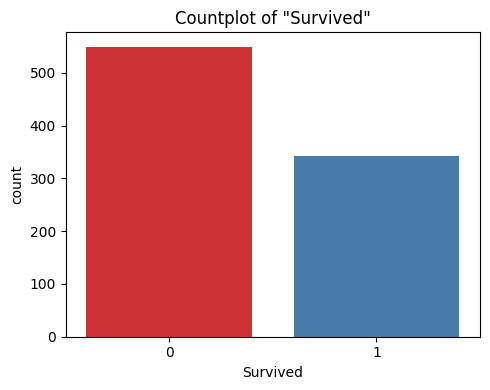

In [26]:
survived, not_survived = len(df[df['Survived'] == 1]), len(df[df['Survived'] == 0])
print(f">>> Survived : {survived}, {round(100*survived/len(df), 2)} %  | Not-survived : {not_survived}, {round(100*not_survived/len(df), 2)} %")

plt.figure(figsize=(5,4))

sns.countplot(data=df, x='Survived', palette='Set1')
plt.title('Countplot of "Survived"')

plt.tight_layout()
plt.show()

#### Categorical columns

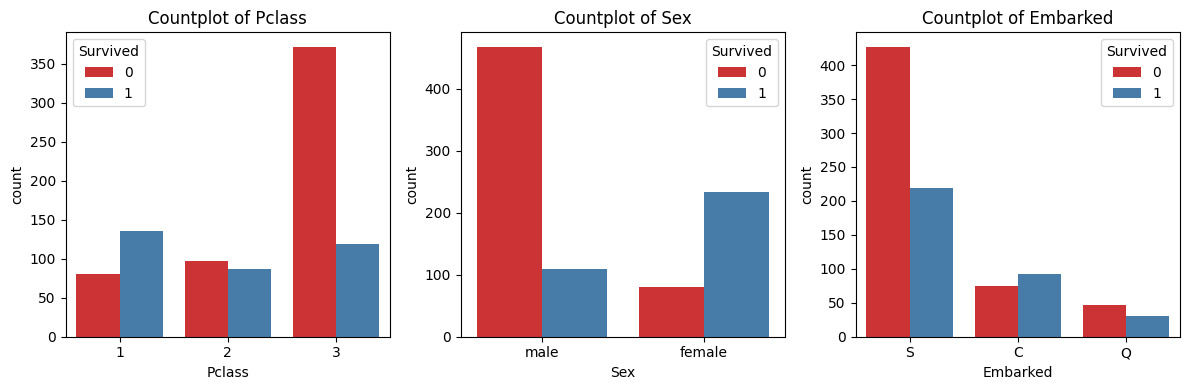

In [27]:
# Countplot of categorical columns

fig, axis = plt.subplots(1,3,figsize=(12,4))

for i, ax in enumerate(axis.flatten()):
    if i < len(cat_columns):
        sns.countplot(data=df, x=cat_columns[i], ax=ax, palette='Set1', hue='Survived')
        ax.set_title(f'Countplot of {cat_columns[i]}')

plt.tight_layout()
plt.show()

#### Numerical columns

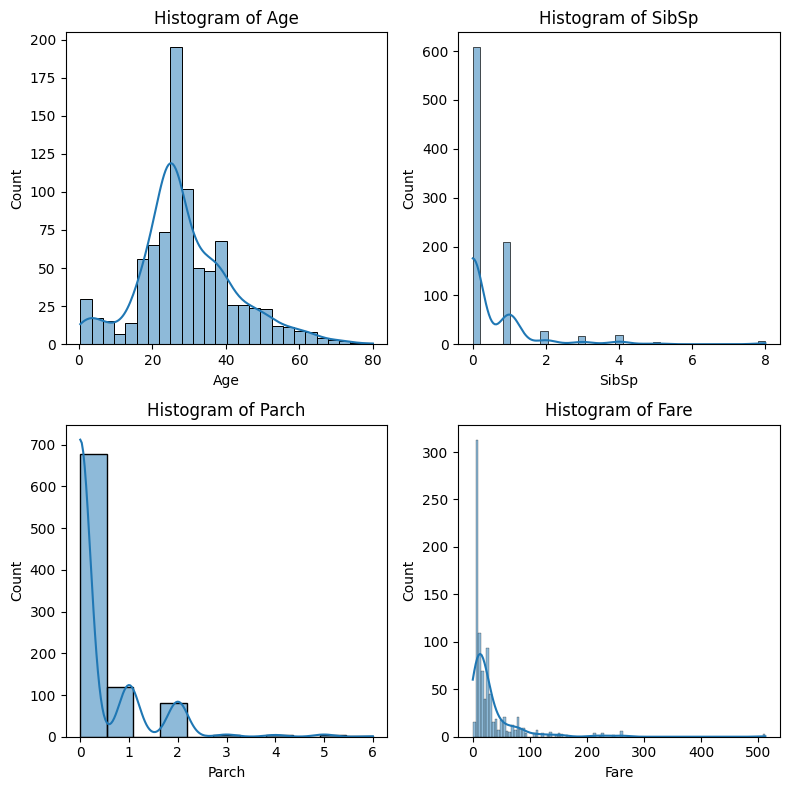

In [28]:
fig, axis = plt.subplots(2,2,figsize=(8,8))

for i, ax in enumerate(axis.flatten()):
    if i < len(num_columns):
        sns.histplot(data=df, x=num_columns[i], ax=ax, kde=True)
        ax.set_title(f'Histogram of {num_columns[i]}')
        
plt.tight_layout()
plt.show()

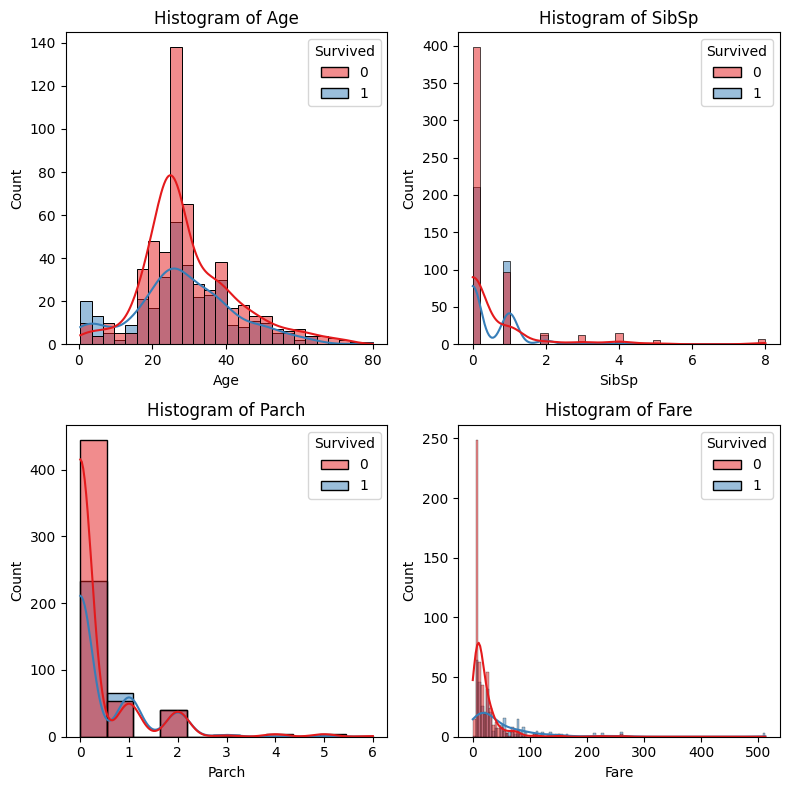

In [29]:
fig, axis = plt.subplots(2,2,figsize=(8,8))

for i, ax in enumerate(axis.flatten()):
    if i < len(num_columns):
        sns.histplot(data=df, x=num_columns[i], ax=ax, kde=True, palette='Set1', hue='Survived')
        ax.set_title(f'Histogram of {num_columns[i]}')
        
plt.tight_layout()
plt.show()

## ▶ Dataset preparation

In [30]:
df = df.set_index('PassengerId')

In [31]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [32]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [33]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


#### Hanlding Categorical data:

In [34]:
# Encode Categorical data

is_male = pd.get_dummies(X['Sex'], drop_first=True)

embarked_from = pd.get_dummies(X['Embarked'], drop_first=True)

which_class = pd.get_dummies(X['Pclass'], drop_first=True)
which_class.rename(columns = {2:'class_2', 3:'class_3'}, inplace= True)

In [35]:
X = pd.concat([X, is_male, embarked_from, which_class], axis=1)

In [36]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,male,Q,S,class_2,class_3
PassengerId,,,,,,,,,,,,
1,3,male,22.0,1,0,7.2500,S,True,False,True,False,True
2,1,female,38.0,1,0,71.2833,C,False,False,False,False,False
3,3,female,26.0,0,0,7.9250,S,False,False,True,False,True
4,1,female,35.0,1,0,53.1000,S,False,False,True,False,False
5,3,male,35.0,0,0,8.0500,S,True,False,True,False,True


In [37]:
X = X.drop(['Sex', 'Embarked', 'Pclass'], axis=1)

#### Handling Numerical data:

In [38]:
X.head()

,Age,SibSp,Parch,Fare,male,Q,S,class_2,class_3
PassengerId,,,,,,,,,
1,22.0,1,0,7.2500,True,False,True,False,True
2,38.0,1,0,71.2833,False,False,False,False,False
3,26.0,0,0,7.9250,False,False,True,False,True
4,35.0,1,0,53.1000,False,False,True,False,False
5,35.0,0,0,8.0500,True,False,True,False,True


In [39]:
X[num_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,891.0,29.252716,13.211959,0.42,22.0000,26.0000,37.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


`num_cols` needs standarization, **but before that let's do train test split to avoid data leakage.**

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [42]:
X_train.head()

,Age,SibSp,Parch,Fare,male,Q,S,class_2,class_3
PassengerId,,,,,,,,,
7,54.0,0,0,51.8625,True,False,True,False,False
719,25.0,0,0,15.5000,True,True,False,False,True
686,25.0,1,2,41.5792,True,False,False,True,False
74,26.0,1,0,14.4542,True,False,False,False,True
883,22.0,0,0,10.5167,False,False,True,False,True


In [43]:
final_columns = X_train.columns
final_columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'male', 'Q', 'S', 'class_2',
       'class_3'],
      dtype='object')

In [44]:
num_columns

['Age', 'SibSp', 'Parch', 'Fare']

In [45]:
X_train_num_cols = X_train[num_columns]
X_test_num_cols = X_test[num_columns]

In [46]:
from sklearn.preprocessing import StandardScaler

In [47]:
scalar = StandardScaler()

In [48]:
scaled_num_array_train = scalar.fit_transform(X_train_num_cols)
scaled_num_array_test = scalar.transform(X_test_num_cols)

In [49]:
X_train = X_train.drop(num_columns, axis=1)
train_data = np.c_[scaled_num_array_train, np.array(X_train)]


X_test = X_test.drop(num_columns, axis=1)
test_data  = np.c_[scaled_num_array_test, np.array(X_test)]

In [50]:
pd.DataFrame(train_data, columns=final_columns)

,Age,SibSp,Parch,Fare,male,Q,S,class_2,class_3
0,1.902265,-0.469837,-0.463993,0.387842,1.0,0.0,1.0,0.0,0.0
1,-0.307836,-0.469837,-0.463993,-0.319081,1.0,1.0,0.0,0.0,1.0
2,-0.307836,0.344183,2.016183,0.187924,1.0,0.0,0.0,1.0,0.0
3,-0.231626,0.344183,-0.463993,-0.339412,1.0,0.0,0.0,0.0,1.0
4,-0.536467,-0.469837,-0.463993,-0.415961,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
591,-0.612678,-0.469837,-0.463993,-0.471692,0.0,0.0,1.0,0.0,1.0
592,0.682899,-0.469837,-0.463993,-0.017745,1.0,0.0,1.0,0.0,0.0
593,0.911530,1.158202,-0.463993,-0.346137,1.0,0.0,1.0,0.0,1.0
594,-1.146151,0.344183,2.016183,1.712501,0.0,0.0,1.0,0.0,0.0


In [51]:
pd.DataFrame(test_data, columns=final_columns)

,Age,SibSp,Parch,Fare,male,Q,S,class_2,class_3
0,-0.307836,0.344183,0.776095,-0.324022,1.0,0.0,0.0,0.0,1.0
1,0.149426,-0.469837,-0.463993,-0.416285,1.0,0.0,1.0,1.0,0.0
2,-0.688888,-0.469837,-0.463993,-0.466346,1.0,0.0,1.0,0.0,1.0
3,-1.755834,-0.469837,0.776095,0.021136,0.0,0.0,1.0,1.0,0.0
4,-1.146151,0.344183,-0.463993,-0.401866,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
290,-0.765099,-0.469837,-0.463993,-0.471692,1.0,0.0,1.0,0.0,1.0
291,0.873425,-0.469837,-0.463993,-0.469748,1.0,1.0,0.0,0.0,1.0
292,-2.136886,-0.469837,2.016183,-0.314382,0.0,0.0,0.0,0.0,1.0
293,-0.307836,-0.469837,2.016183,-0.324022,0.0,0.0,0.0,0.0,1.0


## ▶ Model Training/Evaluation

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [53]:
rfc = RandomForestClassifier()

In [54]:
rfc.fit(train_data, y_train)

RandomForestClassifier()

In [55]:
rfc_predictions  = rfc.predict(test_data)

In [56]:
print(f'>> Random Forest Classifier - Accuracy: {round(accuracy_score(y_test, rfc_predictions)*100, 2)} \n')

cm = confusion_matrix(y_test, rfc_predictions)
print(f'>> Random Forest Classifier - Confusion Matrix: \n {cm} \n')

print(f'>> Random Forest Classifier - Classification Report: \n {classification_report(y_test, rfc_predictions)} \n')

>> Random Forest Classifier - Accuracy: 79.66 

>> Random Forest Classifier - Confusion Matrix: 
 [[149  26]
 [ 34  86]] 

>> Random Forest Classifier - Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       175
           1       0.77      0.72      0.74       120

    accuracy                           0.80       295
   macro avg       0.79      0.78      0.79       295
weighted avg       0.80      0.80      0.80       295
 



In [57]:
from xgboost import XGBClassifier

In [58]:
xgbC = XGBClassifier()

In [59]:
xgbC.fit(train_data, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [60]:
xgbC_predictions  = xgbC.predict(test_data)

In [61]:
print(f'>> XGBoost Classifier - Accuracy: {round(accuracy_score(y_test, xgbC_predictions)*100, 2)} \n')

cm = confusion_matrix(y_test, xgbC_predictions)
print(f'>> XGBoost Classifier - Confusion Matrix: \n {cm} \n')

print(f'>> XGBoost Classifier - Classification Report: \n {classification_report(y_test, xgbC_predictions)} \n')

>> XGBoost Classifier - Accuracy: 78.98 

>> XGBoost Classifier - Confusion Matrix: 
 [[148  27]
 [ 35  85]] 

>> XGBoost Classifier - Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       175
           1       0.76      0.71      0.73       120

    accuracy                           0.79       295
   macro avg       0.78      0.78      0.78       295
weighted avg       0.79      0.79      0.79       295
 



Both **`RandomForestClassification`** and **`XGBoostclassifier`** looks promising, let's work on hyper-paramter tuning.

##### RFC Hyperparamater Tuning

In [62]:
from sklearn.model_selection import GridSearchCV

In [63]:
classifier = RandomForestClassifier()

In [64]:
param_grid = { 
    "n_estimators": [100,150,200],
    "max_depth": [None,3,4,5,6,7,8],
    "criterion":["gini", "entropy", "log_loss"]
}

In [65]:
gs = GridSearchCV(classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=3)

In [66]:
gs.fit(train_data, y_train)

Fitting 5 folds for each of 63 candidates, totalling 315 fits
[CV 1/5] END criterion=gini, max_depth=None, n_estimators=100;, score=0.817 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=None, n_estimators=100;, score=0.765 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=None, n_estimators=100;, score=0.765 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=None, n_estimators=100;, score=0.790 total time=   0.2s
[CV 5/5] END criterion=gini, max_depth=None, n_estimators=100;, score=0.815 total time=   0.2s
[CV 1/5] END criterion=gini, max_depth=None, n_estimators=150;, score=0.800 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=None, n_estimators=150;, score=0.765 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=None, n_estimators=150;, score=0.773 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=None, n_estimators=150;, score=0.790 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=None, n_estimators=150;, score=0.824 total t

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 3, 4, 5, 6, 7, 8],
                         'n_estimators': [100, 150, 200]},
             scoring='accuracy', verbose=3)

In [67]:
gs.best_params_

{'criterion': 'entropy', 'max_depth': 4, 'n_estimators': 100}

In [68]:
gs.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=4)

In [69]:
best_model_rfc = gs.best_estimator_

In [70]:
print(f'>> Tuned Random Forest Classifier - Accuracy: {round(best_model_rfc.score(test_data, y_test)*100, 2)} \n')

>> Tuned Random Forest Classifier - Accuracy: 82.37 



##### XGBoost Hyperparamater Tuning

In [71]:
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
}

In [72]:
classifier = XGBClassifier()

In [73]:
gs = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='accuracy', verbose=3)

In [74]:
gs.fit(train_data, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.758 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.891 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.782 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.748 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.807 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.758 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.891 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.782 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.748 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.807 to

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=3)

In [75]:
gs.best_params_

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}

In [76]:
gs.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [77]:
best_model_xgb = gs.best_estimator_

In [78]:
print(f'>> Tuned XGBoost Classifier - Accuracy: {round(best_model_xgb.score(test_data, y_test)*100, 2)} \n')

>> Tuned XGBoost Classifier - Accuracy: 83.05 



## ▶ Save for Kaggle-submission:

In [79]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [80]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [81]:
print('Shape:', test_df.shape, f'| Rows: {test_df.shape[0]}, Columns: {test_df.shape[1]}')

Shape: (418, 11) | Rows: 418, Columns: 11


In [82]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [83]:
test_df = test_df.drop(['Cabin', 'Name', 'Ticket'], axis=1)

In [84]:
test_df['Age'] = test_df[['Age', 'Pclass']].apply(fill_missing_age, axis=1)

In [85]:
test_df.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           1
Embarked       0
dtype: int64

In [86]:
test_df[pd.isna(test_df['Fare'])]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,male,60.5,0,0,NaN,S


In [87]:
mean_fare_for_missing_data = test_df[(test_df['Pclass'] == 3) & (test_df['Sex'] == 'male') & (test_df['Embarked'] == 'S') & (test_df['SibSp'] == 0) & (test_df['Parch'] == 0)]['Fare'].mean()

In [88]:
test_df['Fare'] = test_df['Fare'].fillna(mean_fare_for_missing_data)

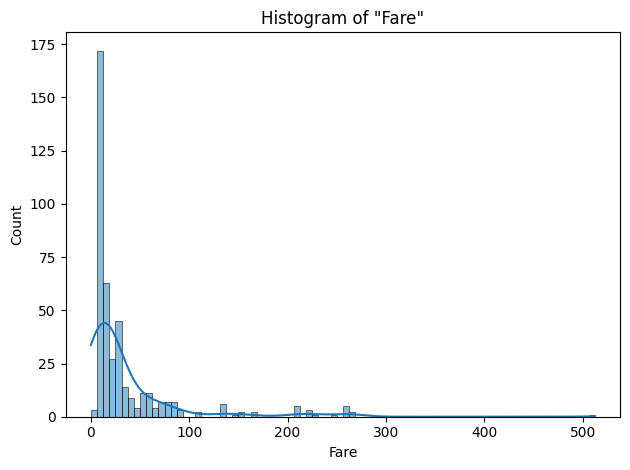

In [89]:
sns.histplot(data=test_df, x='Fare', palette='Set1', kde=True)
plt.title('Histogram of "Fare"')
plt.tight_layout()
plt.show()

In [90]:
test_df.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

In [91]:
test_df = test_df.set_index('PassengerId')

In [92]:
test_X = test_df

In [93]:
test_X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,male,34.5,0,0,7.8292,Q
893,3,female,47.0,1,0,7.0000,S
894,2,male,62.0,0,0,9.6875,Q
895,3,male,27.0,0,0,8.6625,S
896,3,female,22.0,1,1,12.2875,S


In [94]:
# Encode Categorical data

is_male = pd.get_dummies(test_X['Sex'], drop_first=True)

embarked_from = pd.get_dummies(test_X['Embarked'], drop_first=True)

which_class = pd.get_dummies(test_X['Pclass'], drop_first=True)
which_class.rename(columns = {2:'class_2', 3:'class_3'}, inplace= True)

In [95]:
test_X = pd.concat([test_X, is_male, embarked_from, which_class], axis=1)

In [96]:
test_X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,male,Q,S,class_2,class_3
PassengerId,,,,,,,,,,,,
892,3,male,34.5,0,0,7.8292,Q,True,True,False,False,True
893,3,female,47.0,1,0,7.0000,S,False,False,True,False,True
894,2,male,62.0,0,0,9.6875,Q,True,True,False,True,False
895,3,male,27.0,0,0,8.6625,S,True,False,True,False,True
896,3,female,22.0,1,1,12.2875,S,False,False,True,False,True


In [97]:
test_X = test_X.drop(['Sex', 'Embarked', 'Pclass'], axis=1)

In [98]:
test_X.head()

,Age,SibSp,Parch,Fare,male,Q,S,class_2,class_3
PassengerId,,,,,,,,,
892,34.5,0,0,7.8292,True,True,False,False,True
893,47.0,1,0,7.0000,False,False,True,False,True
894,62.0,0,0,9.6875,True,True,False,True,False
895,27.0,0,0,8.6625,True,False,True,False,True
896,22.0,1,1,12.2875,False,False,True,False,True


In [99]:
test_X_num_cols = test_X[num_columns]

In [100]:
test_scaled_num_array = scalar.transform(test_X_num_cols)

In [101]:
test_X = test_X.drop(num_columns, axis=1)
test_data_submission  = np.c_[test_scaled_num_array, np.array(test_X)]

In [102]:
pd.DataFrame(test_data_submission, columns=final_columns)

,Age,SibSp,Parch,Fare,male,Q,S,class_2,class_3
0,0.416162,-0.469837,-0.463993,-0.468208,1.0,1.0,0.0,0.0,1.0
1,1.368792,0.344183,-0.463993,-0.484329,0.0,0.0,1.0,0.0,1.0
2,2.511948,-0.469837,-0.463993,-0.432081,1.0,1.0,0.0,1.0,0.0
3,-0.155415,-0.469837,-0.463993,-0.452008,1.0,0.0,1.0,0.0,1.0
4,-0.536467,0.344183,0.776095,-0.381535,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
413,-0.307836,-0.469837,-0.463993,-0.463916,1.0,0.0,1.0,0.0,1.0
414,0.759109,-0.469837,-0.463993,1.496706,0.0,0.0,0.0,0.0,0.0
415,0.721004,-0.469837,-0.463993,-0.479469,1.0,0.0,1.0,0.0,1.0
416,-0.307836,-0.469837,-0.463993,-0.463916,1.0,0.0,1.0,0.0,1.0


### Save results:

In [103]:
result_xgb, result_rfc = pd.DataFrame(), pd.DataFrame()

In [104]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [105]:
result_xgb['PassengerId'], result_rfc['PassengerId'] = test_df['PassengerId'], test_df['PassengerId']

In [106]:
result_xgb['Survived'] = best_model_xgb.predict(test_data_submission)
result_rfc['Survived'] = best_model_rfc.predict(test_data_submission)

In [107]:
result_xgb.set_index('PassengerId', inplace=True)
result_rfc.set_index('PassengerId', inplace=True)

In [108]:
result_xgb.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [109]:
result_rfc.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [110]:
result_xgb.to_csv('titanic_kaggle_submission_xgboost_v1.csv')

In [111]:
result_rfc.to_csv('titanic_kaggle_submission_rfc_v1.csv')